In [1]:
!pip uninstall qiskit qiskit_machine_learning qiskit_aer
!pip install qiskit==0.43.3 qiskit_machine_learning==0.6.1 qiskit_aer==0.12.2

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 4.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 148.7/148.7 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 82.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.5/241.5 kB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 86.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 31.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 60.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 23.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.0/109.0 kB 6.9 MB/s eta 0:00:00
  Created wheel for qiskit: filen

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from qiskit.utils import QuantumInstance
from qiskit.circuit.library import ZZFeatureMap
from qiskit_machine_learning.kernels import QuantumKernel
from qiskit_machine_learning.algorithms import QSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import joblib
import warnings
from qiskit import Aer
warnings.filterwarnings("ignore")

In [2]:
# ============================ #
#        Configurable Params   #
# ============================ #
NUM_FEATURES = 15  # Set -1 to use all available features as qubits
TRAIN_SIZE = 7000  # Set -1 to use all available samples
CIRCUIT_REPS = 2     # Depth of feature map
TEST_RATIO = 0.25

#case 1: full samples and full features
#case 2: 10000 samples and full features
#case 3: full samples and reduce features
#case 4: 10000 samples and reduces features
#case 5: reduces samples and features to fit the harware specs

In [7]:
# ============================ #
#         Load Dataset         # enter train and test dataset generated in the previous script here.
# ============================ #
print("Loading angle-encoded training and testing datasets...")
train_df = pd.read_excel('/content/tii_ssrc23_angle_encoded_train.xlsx')
test_df = pd.read_excel('/content/tii_ssrc23_angle_encoded_test.xlsx')

full_df = pd.concat([train_df, test_df], ignore_index=True)
X_full = full_df.drop(columns=['label'])
y_full = full_df['label']

print(f"Total Samples: {len(X_full)}, Total Classes: {len(np.unique(y_full))}")

Loading angle-encoded training and testing datasets...
Total Samples: 100000, Total Classes: 27


In [8]:
# ============================ #
#   Stratified Downsampling    #
# ============================ #
num_classes = len(np.unique(y_full))

# Handle full dataset case
if TRAIN_SIZE == -1 or TRAIN_SIZE >= len(X_full):
    print("Using full dataset for training and testing (no downsampling)")
    X_train = X_full
    y_train = y_full
    X_test = pd.DataFrame([], columns=X_full.columns)
    y_test = pd.Series([], dtype=int)

else:
    TEST_SIZE = int(TEST_RATIO * TRAIN_SIZE)

    # Ensure test size has enough samples for stratification
    if TEST_SIZE < num_classes:
        min_train = int(np.ceil(num_classes / (1 - TEST_RATIO)))
        raise ValueError(
            f"TRAIN_SIZE={TRAIN_SIZE} too small for {num_classes} classes with {int(TEST_RATIO*100)}% test split.\n"
            f"Set TRAIN_SIZE to at least {min_train}."
        )

    sss = StratifiedShuffleSplit(n_splits=1, train_size=TRAIN_SIZE, test_size=TEST_SIZE, random_state=42)
    for train_index, test_index in sss.split(X_full, y_full):
        X_train = X_full.iloc[train_index]
        y_train = y_full.iloc[train_index]
        X_test = X_full.iloc[test_index]
        y_test = y_full.iloc[test_index]

# ============================ #
#     Feature Selection        #
# ============================ #

# Fixed list of manually selected features
selected_features = [
    'num__Fwd Packet Length Min',
    'num__Packet Length Mean',
    'num__Packet Length Max',
    'num__FWD Init Win Bytes',
    'num__Average Packet Size',
    'num__Fwd PSH Flags',
    'num__ACK Flag Count',
    'num__Fwd URG Flags',
    'num__URG Flag Count',
    'num__PSH Flag Count',
    'num__RST Flag Count',
    'num__FIN Flag Count',
    'num__SYN Flag Count',
    'num__CWR Flag Count',
    'num__ECE Flag Count'
]

# Filter only these features from the dataset
X_train = X_train[selected_features]
X_test = X_test[selected_features]
NUM_FEATURES = len(selected_features)

print(f"\nUsing manually selected {NUM_FEATURES} features (qubits):")
for idx, feat in enumerate(selected_features, 1):
    print(f"{idx:>2}. {feat}")




Using manually selected 15 features (qubits):
 1. num__Fwd Packet Length Min
 2. num__Packet Length Mean
 3. num__Packet Length Max
 4. num__FWD Init Win Bytes
 5. num__Average Packet Size
 6. num__Fwd PSH Flags
 7. num__ACK Flag Count
 8. num__Fwd URG Flags
 9. num__URG Flag Count
10. num__PSH Flag Count
11. num__RST Flag Count
12. num__FIN Flag Count
13. num__SYN Flag Count
14. num__CWR Flag Count
15. num__ECE Flag Count


In [9]:
print(f"\nQSVC with {NUM_FEATURES} qubits, {len(X_train)} training samples, {len(X_test)} test samples")

backend = Aer.get_backend('aer_simulator_statevector')
qi = QuantumInstance(backend=backend, shots=1024, seed_simulator=42, seed_transpiler=42)
feature_map = ZZFeatureMap(feature_dimension=NUM_FEATURES, reps=CIRCUIT_REPS, entanglement='linear')
quantum_kernel = QuantumKernel(feature_map=feature_map, quantum_instance=qi)


QSVC with 15 qubits, 7000 training samples, 1750 test samples


In [10]:
model = QSVC(quantum_kernel=quantum_kernel)

print("Training QSVC...")
model.fit(X_train, y_train)

Training QSVC...


QSVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
     decision_function_shape='ovr', degree=3, gamma='scale', max_iter=-1,
     probability=False,
     quantum_kernel=<qiskit_machine_learning.kernels.quantum_kernel.QuantumKernel object at 0x7c45cef66bd0>,
     random_state=None, shrinking=True, tol=0.001, verbose=False)

In [12]:
# ============================ #
#         Evaluation           #
# ============================ #
y_pred = model.predict(X_test.values)
acc = accuracy_score(y_test, y_pred)

print(f"\nQSVM Accuracy: {acc:.4f}")
print("Classification Report:")
print(classification_report(y_test, y_pred))


QSVM Accuracy: 0.9709
Classification Report:
              precision    recall  f1-score   support

           1       0.00      0.00      0.00         5
           2       1.00      1.00      1.00         1
           4       0.00      0.00      0.00         1
           5       0.00      0.00      0.00         1
           6       0.95      0.92      0.93       190
           7       0.98      0.99      0.99       170
           8       0.99      1.00      1.00       171
           9       0.96      1.00      0.98       158
          10       0.92      0.63      0.75        19
          11       0.98      0.98      0.98       187
          12       1.00      0.99      0.99       235
          13       1.00      1.00      1.00       176
          14       0.80      0.89      0.84        62
          15       1.00      1.00      1.00       174
          16       0.94      1.00      0.97       179
          17       1.00      1.00      1.00         1
          18       0.93      1.00  

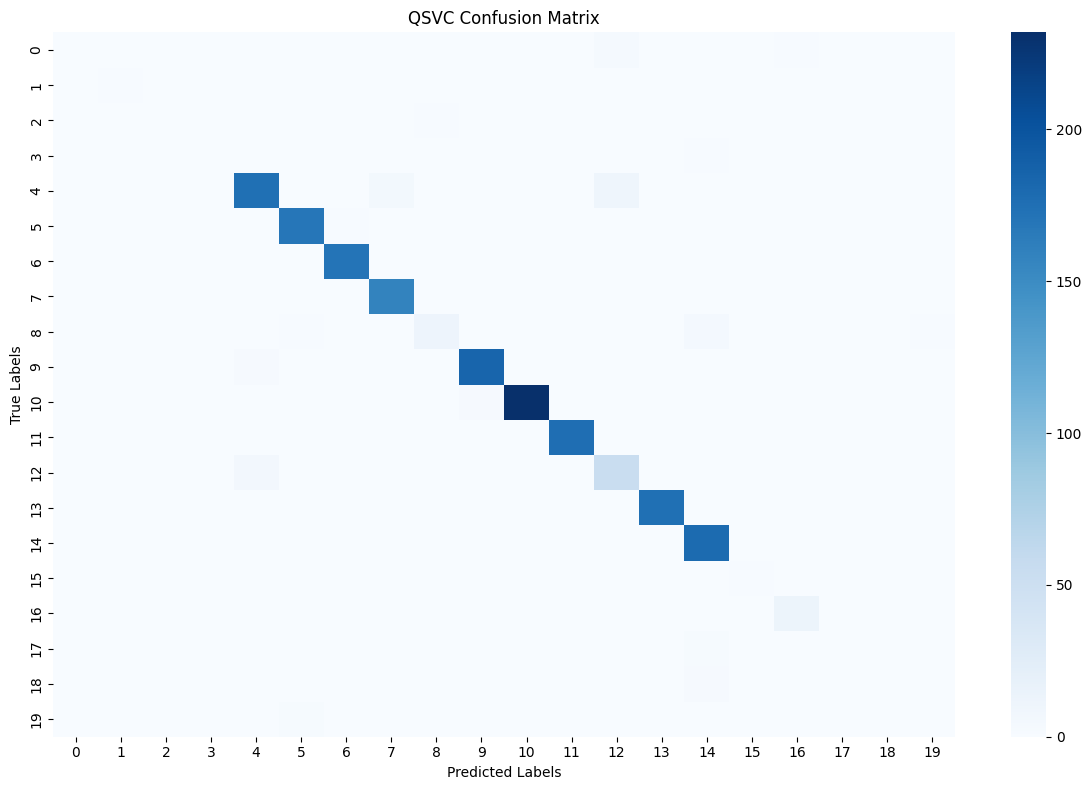

In [13]:
# ============================ #
#     Confusion Matrix Plot    #
# ============================ #
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(12, 8))
sns.heatmap(cm, annot=False, cmap='Blues', fmt='d')
plt.title("QSVC Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.tight_layout()
plt.show()

In [15]:
# ============================ #
#         Save Model           #
# ============================ #
joblib.dump(model, '/content/qsvc_15_7new.joblib')
print("Model saved as 'qsvc_ids.joblib'")

Model saved as 'qsvc_ids.joblib'
